## Exercise 3.12, taken from Montgomery, Douglas C., et al. <u>Introduction to Linear Regression Analysis</u>, John Wiley & Sons, Incorporated, 2012.

A chemical engineer studied the effect of the amount of surfactant and time on clathrate formation. Clathrates are used as cool storage media. Table B.8 summarizes the experimental results.

**a. Fit a multiple linear regression model relating clathrate formation to these regressors.**

Given:

 * y = Clathrate Formation
 * x1 = level of surfactant
 * x2 = time of reaction
 
The model equation of clathrate formation is:

    y_hat = beta_0 + beta_1(x1) + beta_2(x2) + beta_12(x1)(x2)

The multiple linear regression model is:

    y_hat = 12.5013 + 256.7374(x1) + 0.0988(x2) + 0.7613(x1)(x2)

In [52]:
import pandas as pd
import statsmodels.api as sm

# Import clathrate formation data
dataset = pd.read_csv("https://raw.githubusercontent.com/forestwhite/Regression/main/data/data-table-B8.csv")
# display(dataset.head(8))

# Option 1: Add column(s) for interaction terms, uses explicit index names because python doesn't gracefully handle indices
# dataset['x1x2'] = dataset['x1']*dataset['x2']
# Create Xs and y; for option 1, include term 'x1x2'
# Xb = sm.add_constant(dataset[['x1','x2','x1x2']])
# y1 = dataset['y']
# Generate a linear model 
# model = sm.OLS(y1, Xb)

# Option 2: use scikit-learn's Polynomial features to generate interaction terms
# Note: sklearn a.k.a. scikit-learn is not always installed and configured 
# to operate in jupyter environment. Command line "conda install scikit-learn" in 
# the jupyter environment is often required, along with updates to other libraries.
from sklearn.preprocessing import PolynomialFeatures

# Create Xs and y;
X = dataset[['x1','x2']]
y1 = dataset['y']

# degree = 2 indicates the second order interactions
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_inter = interaction.fit_transform(X)

# The linear model generates sequential x# labels, which hides which interactions are in which variable
#X_inter_const = sm.add_constant(X_inter)
#model = sm.OLS(y1, X_inter_const).fit()
# interaction.get_feature_names_out() is a key for the interactions, used below to 
#print(interaction.get_feature_names_out())

# create a dictionary that maps X using the itertools.count() function, simlar to an enumeration
from itertools import count
x_to_feature = dict(zip(('x{}'.format(i) for i in count()), X.columns))

# substitute x# with column names or combinations of column names from the dataset,
# replaces spaces with underscores to ease column references

import re
# necessary so `x11` enters the loop before `x1`, preventing duplicate x1 match
feature_keys = list(x_to_feature.keys())[::-1]
features = []

for feature in interaction.get_feature_names_out():
    feature = re.sub(' ', '_', feature)
    features.append(feature)

X_all_inter = pd.DataFrame(X_inter, columns=features)
X_all_inter_const = sm.add_constant(X_all_inter)

lm312 = sm.OLS(y1, X_all_inter_const).fit()
display(lm312.params)

const     12.501284
x1       256.737401
x2         0.098792
x1_x2      0.761270
dtype: float64

**b. Test for significance of regression. What conclusions can you draw?**

Besides a few outliers, the variance is constant/random for this data set, as demonstrated in the residual vs. fitted plot.

Additionally, the data set demonstrates normality as demonstrated by the normal probability plot.

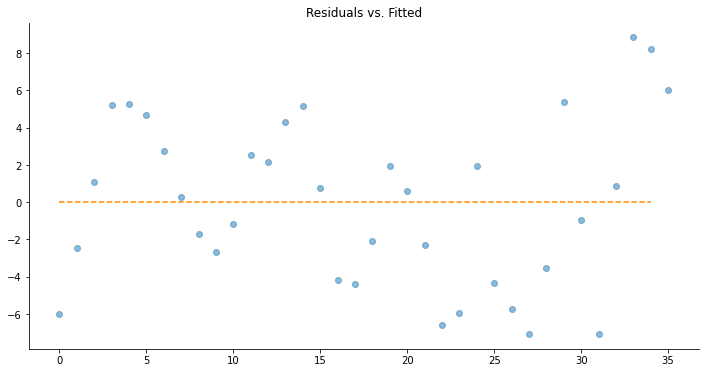

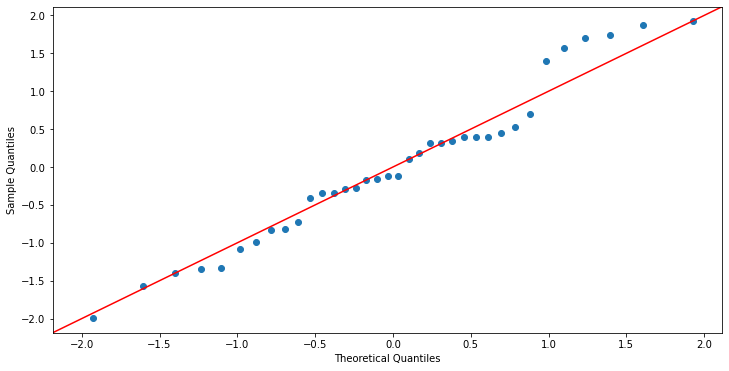

In [74]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Import clathrate formation data
dataset = pd.read_csv("https://raw.githubusercontent.com/forestwhite/Regression/main/data/data-table-B8.csv")

from sklearn.preprocessing import PolynomialFeatures

# Create Xs and y;
X = dataset[['x1','x2']]
y1 = dataset['y']

# degree = 2 indicates the second order interactions
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)

# create a dictionary that maps X using the itertools.count() function, simlar to an enumeration
from itertools import count
x_to_feature = dict(zip(('x{}'.format(i) for i in count()), X.columns))

# substitute x# with column names or combinations of column names from the dataset,
# replaces spaces with underscores to ease column references

import seaborn as sns
# necessary so `x11` enters the loop before `x1`, preventing duplicate x1 match
feature_keys = list(x_to_feature.keys())[::-1]
features = []

for feature in interaction.get_feature_names_out():
    feature = re.sub(' ', '_', feature)
    features.append(feature)
X_all_inter = pd.DataFrame(X_inter, columns=features)
X_all_inter_const = sm.add_constant(X_all_inter)
lm312 = sm.OLS(y1, X_all_inter_const).fit()

# credit to Jeff Macaluso for demonstrating model adequecy tests
# see https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Calculating residuals for the plot
predictions = lm312.predict()
df_results = pd.DataFrame({'Actual': y1, 'Predicted': predictions})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

# Plotting the residuals
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine
plt.title('Residuals vs. Fitted')
plt.show()

# create Q-Q plot to test normality using statsmodels
fig, ax = plt.subplots(figsize=(12, 6))
fig = sm.qqplot(dataset['y'], fit=True, line='45', ax = ax)

plt.show()

**c. Use t tests to assess the contribution of each regressor to the model. Discuss your findings.**

A very low p-value (2.318e-13) and relatively high R-squared coefficient (0.8518) support that the model is overall significant and a reasonably good fit for actual population from which this sample is taken. For each individual predictor variable, we have:

 * (Intercept): t = 6.602 -> Pr(>|t|) = 0.000 < 0.05, therefore significant
 * x1: t = 3.482 -> Pr(>|t|) = 0.001 < 0.05, therefore significant
 * x2: t = 8.281 -> Pr(>|t|) = 0.000 < 0.05, therefore significant
 * x1:x2: t = 1.492 -> Pr(>|t|) = 0.146 > 0.05, therefore not significant 

In [51]:
import pandas as pd
import statsmodels.api as sm

# Import clathrate formation data
dataset = pd.read_csv("https://raw.githubusercontent.com/forestwhite/Regression/main/data/data-table-B8.csv")

from sklearn.preprocessing import PolynomialFeatures

# Create Xs and y;
X = dataset[['x1','x2']]
y1 = dataset['y']

# degree = 2 indicates the second order interactions
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)

# create a dictionary that maps X using the itertools.count() function, simlar to an enumeration
from itertools import count
x_to_feature = dict(zip(('x{}'.format(i) for i in count()), X.columns))

# substitute x# with column names or combinations of column names from the dataset,
# replaces spaces with underscores to ease column references

import seaborn as sns
# necessary so `x11` enters the loop before `x1`, preventing duplicate x1 match
feature_keys = list(x_to_feature.keys())[::-1]
features = []

import re
for feature in interaction.get_feature_names_out():
    feature = re.sub(' ', '_', feature)
    features.append(feature)
X_all_inter = pd.DataFrame(X_inter, columns=features)
X_all_inter_const = sm.add_constant(X_all_inter)

lm312 = sm.OLS(y1, X_all_inter_const).fit()
display(lm312.summary().tables[1].data[1][4])
display(lm312.summary().tables[1].data[2][4])
display(lm312.summary().tables[1].data[3][4])
display(lm312.summary().tables[1].data[4][4])

' 0.000'

' 0.001'

' 0.000'

' 0.146'

**d. Calculate R2 and RAdj 2 for this model. Compare these values to the R2 and RAdj 2 for the simple linear regression model relating clathrate formation to time. Discuss your results.**

The computed r-squared and adjusted r-squared values for both models is summarized in the table below:

| model   | r-squared           | adj. r-squared     |
|---------|---------------------|--------------------|
| y~x1+x2 | 0.8415008375400974  | 0.8318948276940428 |
| y~x2    | 0.46761604551975844 | 0.4519576939173985 |

R-squared values are also known as coefficients of determination because this value indicates how much the response fit estimate, y_hat, is determined  by the model predictor variables. In this case, time (x2) alone determines between 45.2% and 46.8% of the y_hat fit, whereas time (x2) and surfuctant (x1) together determine between 83.2% and 84.2% of the y_hat fit. In this way, the 2 variable model is much better at estimating y values than the single variable model.

In [77]:
import pandas as pd
import statsmodels.api as sm

# Import clathrate formation data
dataset = pd.read_csv("https://raw.githubusercontent.com/forestwhite/Regression/main/data/data-table-B8.csv")

# Create Xs and y;
X = dataset[['x1','x2']]
y1 = dataset['y']

X1 = sm.add_constant(X)
result = sm.OLS(y1, X1).fit()
#print dir(result)
display(result.rsquared, result.rsquared_adj)
# 0.8415008375400974 0.8318948276940428

X = dataset[['x2']]
X2 = sm.add_constant(X)
result = sm.OLS(y1, X2).fit()
#print dir(result)
display(result.rsquared, result.rsquared_adj)
# 0.46761604551975844 0.4519576939173985

0.8415008375400974

0.8318948276940428

0.46761604551975844

0.4519576939173985

**e. Find a 95% CI for the regression coefficient for time for both models in part d. Discuss any differences.**

From the linear models, the confidence intervals for beta_2 (time coefficient) are:

 * surfuctant+time: 0.08862340997573717 < beta_2 < 0.12924542726171231
 * time alone: 0.06136762210397215 < beta_2 < 0.13403371454369178
 
When time is the only predictor, the 95% confidence interval for beta_2 coefficient is wider than the 95% confidence interval for beta_2 when there are 2 predictor variables, no matter which method used to calculate the interval. This implies that the model with 2 predictors is more precise than the model with only the time predictor.

In [28]:
import pandas as pd
import statsmodels.api as sm

# Import clathrate formation data
dataset = pd.read_csv("https://raw.githubusercontent.com/forestwhite/Regression/main/data/data-table-B8.csv")

# Create Xs and y for 2-parameter model
X = dataset[['x1','x2']]
y1 = dataset['y']

X1 = sm.add_constant(X)
result = sm.OLS(y1, X1).fit()

display(result.t_test('x2').conf_int(alpha=0.05)[0,0])
display(result.t_test('x2').conf_int(alpha=0.05)[0,1])

# Create x and y for 2-parameter model
X = dataset[['x2']]
X2 = sm.add_constant(X)
result = sm.OLS(y1, X2).fit()

display(result.t_test('x2').conf_int(alpha=0.05)[0,0])
display(result.t_test('x2').conf_int(alpha=0.05)[0,1])

0.08862340997573717

0.12924542726171231

0.06136762210397215

0.13403371454369178